In [1]:
import numpy as np 

# data in/out & eda
import pandas as pd 
#
# visualisations
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go

In [2]:
file_path = "C:\\python\\Thuc_tap\\data.xlsx"
data = pd.read_excel(file_path)

# Hiển thị DataFrame
data

,Time,demand
0,2013-01-01,1.363047e+06
1,2013-02-01,1.628000e+06
2,2013-03-01,2.008000e+06
3,2013-04-01,2.237333e+06
4,2013-05-01,2.680667e+06
...,...,...
103,2021-08-01,2.336760e+06
104,2021-09-01,2.145801e+06
105,2021-10-01,1.896715e+06
106,2021-11-01,1.551155e+06


In [3]:
data.set_index('Time', inplace=True)
data.rename_axis(None, inplace=True)
data

,demand
2013-01-01,1.363047e+06
2013-02-01,1.628000e+06
2013-03-01,2.008000e+06
2013-04-01,2.237333e+06
2013-05-01,2.680667e+06
...,...
2021-08-01,2.336760e+06
2021-09-01,2.145801e+06
2021-10-01,1.896715e+06
2021-11-01,1.551155e+06


In [4]:
from ydata_profiling import ProfileReport
ProfileReport(data)

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

In [5]:
# Bieu do su dung nang luong theo thoi gian
data['Time'] = data.index

# plotting
fig = px.line(data,
              x='Time',
              y='demand',
              title=f'Water Demand (MW) over time [{min(data.index.year)} - {max(data.index.year)}]')
fig.update_traces(line=dict(width=1))
fig.update_layout(xaxis_title='Date & Time (yyyy/mm)',
                  yaxis_title='Water Demand')
fig.show()

In [6]:
from statsmodels.tsa.seasonal import STL
import plotly.express as px
import plotly.graph_objects as go

# Phân tích STL với dữ liệu theo tháng
stl = STL(data['demand'], seasonal=13)
decomposed = stl.fit()

# Định nghĩa hàm vẽ
def plot_decompositions(decompositions, titles, line_widths):
    for d, t, lw in zip(decompositions, titles, line_widths):
        # Chuyển đổi Series thành DataFrame để sử dụng với plotly
        df_d = d.reset_index()
        df_d.columns = ['Datetime', 'Value']  # Đổi tên các cột cho dễ sử dụng
        
        # Vẽ biểu đồ
        fig = px.line(df_d,
                      x='Datetime',
                      y='Value',  # Cột duy nhất sau khi chuyển đổi
                      title=t,
                      height=300)
        
        # Điều chỉnh độ rộng của đường
        fig.update_traces(line=dict(width=lw))
        
        # Thay đổi cách bố trí của các trục và các lề của hình để mô phỏng tight_layout
        fig.update_layout(
            xaxis=dict(
                showticklabels=False,
                linewidth=1
            ),
            yaxis=dict(title=''),
            margin=go.layout.Margin(
                l=40, r=40, b=0, t=40, pad=0
            ),
        )
        
        # Hiển thị biểu đồ
        fig.show()

# Gọi hàm để vẽ biểu đồ
plot_decompositions(decompositions=[decomposed.trend, 
                                    decomposed.seasonal,
                                    decomposed.resid],
                    titles=['Trend', 
                            'Seasonality',
                            'Residuals'],
                    line_widths=[2, 2, 2])

In [7]:
f'The last date time point in our dataframe is: {max(data.index)}'

'The last date time point in our dataframe is: 2021-12-01 00:00:00'

In [8]:
cutoff_date = '2020-12-01'

# Chia tập huấn luyện (train) từ 5 năm trước ngày 31-07-2017
train_start_date = pd.to_datetime(cutoff_date) - pd.DateOffset(years=6)
train = data.loc[(data.index >= train_start_date) & (data.index < cutoff_date)].copy()

# Chia tập kiểm tra (test) từ ngày 31-07-2017 đến cuối
test = data.loc[data.index >= cutoff_date].copy()

In [9]:
print(f'Training shape: {train.shape} \nTesting shape: {test.shape}\n')
print(f'The training set lies between the dates: {min(train.index)} and {max(train.index)}')
print(f'For the testing set, the dates are: {min(test.index)} and {max(test.index)}')

Training shape: (72, 2) 
Testing shape: (13, 2)

The training set lies between the dates: 2014-12-01 00:00:00 and 2020-11-01 00:00:00
For the testing set, the dates are: 2020-12-01 00:00:00 and 2021-12-01 00:00:00


PROPHET

In [10]:
from prophet import Prophet
from prophet.diagnostics import cross_validation

# Giả sử `train` và `test` đã được chia và dữ liệu đã được chuẩn bị như trước đó

# Đổi tên cột để phù hợp với yêu cầu của Prophet
train_prophet = train[['demand']]\
                    .reset_index()\
                    .rename(columns={
                        'index': 'ds', 
                        'demand': 'y'
                    })

test_prophet = test[['demand']]\
                    .reset_index()\
                    .rename(columns={
                        'index': 'ds',
                        'demand': 'y'
                    })

In [11]:
def mape(y_true, y_pred):
    """ Mean Absolute Percentage Error """
    
    # convert to numpy arrays
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    
    # take the percentage error
    pe = (y_true - y_pred) / y_true
    
    # take the absolute values
    ape = np.abs(pe)
    
    # quantify the performance in a single number
    mape = np.mean(ape)
    
    return f'{mape*100:.2f}%'

In [12]:
def is_winter(ds):
    date = pd.to_datetime(ds)
    return (date.month == 1) or (date.month in [11, 12])

def is_spring(ds):
    date = pd.to_datetime(ds)
    return date.month in [2, 3, 4]

def is_summer(ds):
    date = pd.to_datetime(ds)
    return date.month in [5, 6, 7]

def is_autumn(ds):
    date = pd.to_datetime(ds)
    return date.month in [8, 9, 10]

In [13]:
# Thêm các đặc trưng theo mùa vào tập huấn luyện
train_prophet['is_winter'] = train_prophet['ds'].apply(is_winter)
train_prophet['is_spring'] = train_prophet['ds'].apply(is_spring)
train_prophet['is_summer'] = train_prophet['ds'].apply(is_summer)
train_prophet['is_autumn'] = train_prophet['ds'].apply(is_autumn)

# Thêm các đặc trưng theo mùa vào tập kiểm tra
test_prophet['is_winter'] = test_prophet['ds'].apply(is_winter)
test_prophet['is_spring'] = test_prophet['ds'].apply(is_spring)
test_prophet['is_summer'] = test_prophet['ds'].apply(is_summer)
test_prophet['is_autumn'] = test_prophet['ds'].apply(is_autumn)

# Khởi tạo mô hình Prophet
prophet = Prophet(
    yearly_seasonality=True,  
    weekly_seasonality=False
)

# Thêm các chu kỳ mùa vụ theo tháng
prophet.add_seasonality(name='yearly', period=12, fourier_order=10)

# Thêm các chu kỳ mùa vụ theo tháng
prophet.add_seasonality(name='yearly', period=12, fourier_order=10)
prophet.add_seasonality(name='monthly_winter', 
                        period=1,
                        fourier_order=5, 
                        condition_name='is_winter')
prophet.add_seasonality(name='monthly_spring', 
                        period=1,
                        fourier_order=5, 
                        condition_name='is_spring')
prophet.add_seasonality(name='monthly_summer', 
                        period=1,
                        fourier_order=5, 
                        condition_name='is_summer')
prophet.add_seasonality(name='monthly_autumn', 
                        period=1,
                        fourier_order=5, 
                        condition_name='is_autumn')

# Huấn luyện mô hình
prophet.fit(train_prophet)

# Dự đoán trên tập kiểm tra
future = test_prophet.drop(['y'], axis=1)
forecast = prophet.predict(future)

23:25:58 - cmdstanpy - INFO - Chain [1] start processing
23:25:58 - cmdstanpy - INFO - Chain [1] done processing


In [14]:
from sklearn.metrics import mean_absolute_percentage_error
fig = go.Figure()

# Dữ liệu thực tế
fig.add_trace(go.Scatter(x=test_prophet.ds, y=test_prophet.y,
                         mode='lines',
                         name='Test - Ground Truth'))

# Dự đoán của mô hình
fig.add_trace(go.Scatter(x=forecast.ds, y=forecast.yhat,
                         mode='lines', 
                         name='Test - Prediction'))

# Điều chỉnh bố cục
fig.update_traces(line=dict(width=0.5))
fig.update_layout(title='Prophet Forecast of Monthly Water Demand',
                  xaxis_title='Date (yyyy/mm/dd)',
                  yaxis_title='Energy Demand [MW]')

# Hiển thị biểu đồ
fig.show()

# Đánh giá độ chính xác
print(f'MAPE for Prophet\'s predictions: {mape(test_prophet.y, forecast.yhat)}')

MAPE for Prophet's predictions: 9.53%


SARIMA

Kiểm tra tính dừng của dữ liệu không có yếu tố mùa vụ

In [15]:
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm

# Vẽ biểu đồ chuỗi thời gian gốc
plt.figure(figsize=(12, 6))
plt.subplot(2, 1, 1)
plt.plot(train['demand'], label='Original Series')
plt.title('Original Series')
plt.xlabel('Time')
plt.ylabel('Demand')
plt.legend()

# Hàm để vẽ chuỗi thời gian đã sai phân
def plot_differenced_series(data, d):
    diff_data = data['demand']
    for i in range(d):
        diff_data = diff_data.diff().dropna()

    plt.figure(figsize=(12, 6))
    plt.plot(diff_data, label=f'Differenced Series (d={d})')
    plt.title(f'Differenced Series (d={d})')
    plt.xlabel('Time')
    plt.ylabel('Differenced Demand')
    plt.legend()
    plt.show()

# Vẽ chuỗi thời gian đã sai phân với d = 1
plot_differenced_series(train, d=1)

# Vẽ chuỗi thời gian đã sai phân với d = 2
plot_differenced_series(train, d=2)

# Vẽ chuỗi thời gian đã sai phân với d = 3
plot_differenced_series(train, d=3)

# Vẽ chuỗi thời gian đã sai phân với d = 4
plot_differenced_series(train, d=4)

C:\Users\ACER\AppData\Local\Temp\ipykernel_28756\267103048.py:26: UserWarning:

FigureCanvasAgg is non-interactive, and thus cannot be shown



Vẽ ACF, PACF của dữ liệu đã sai phân tổng quát

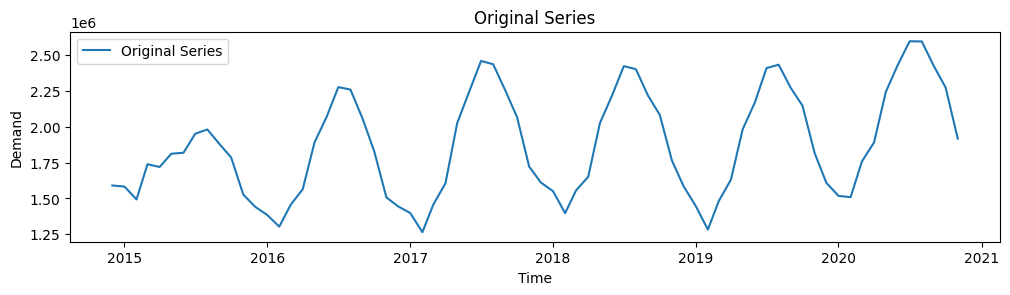

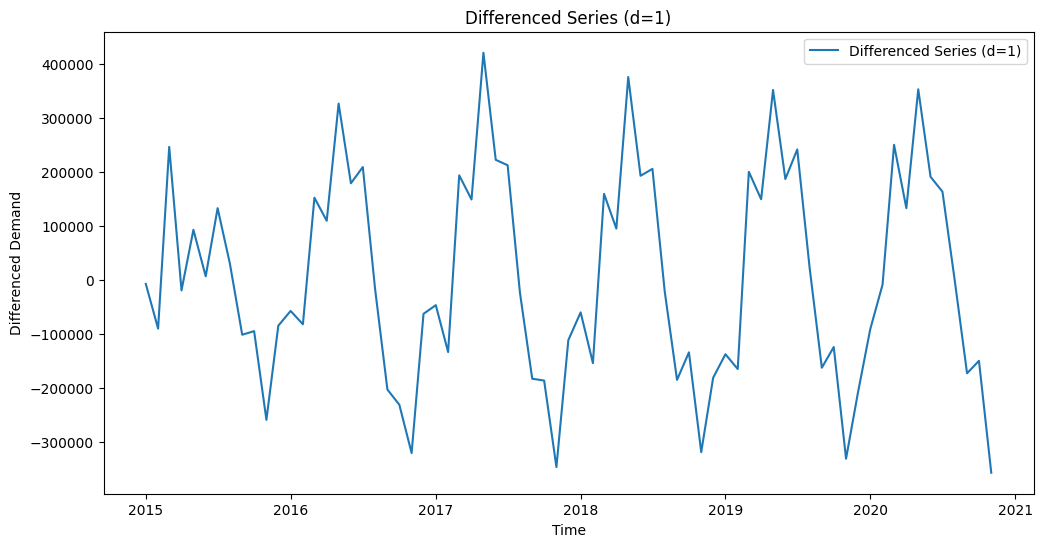

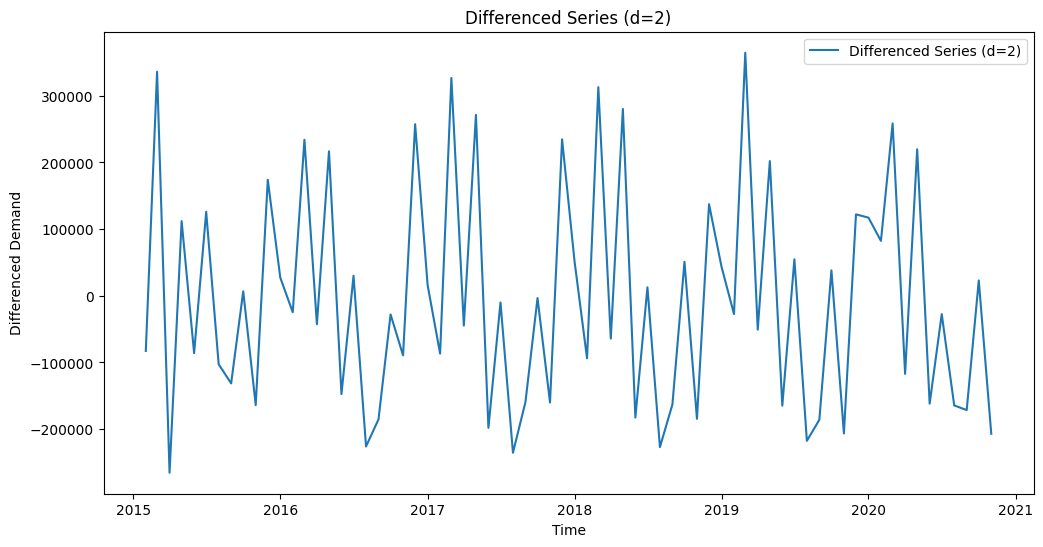

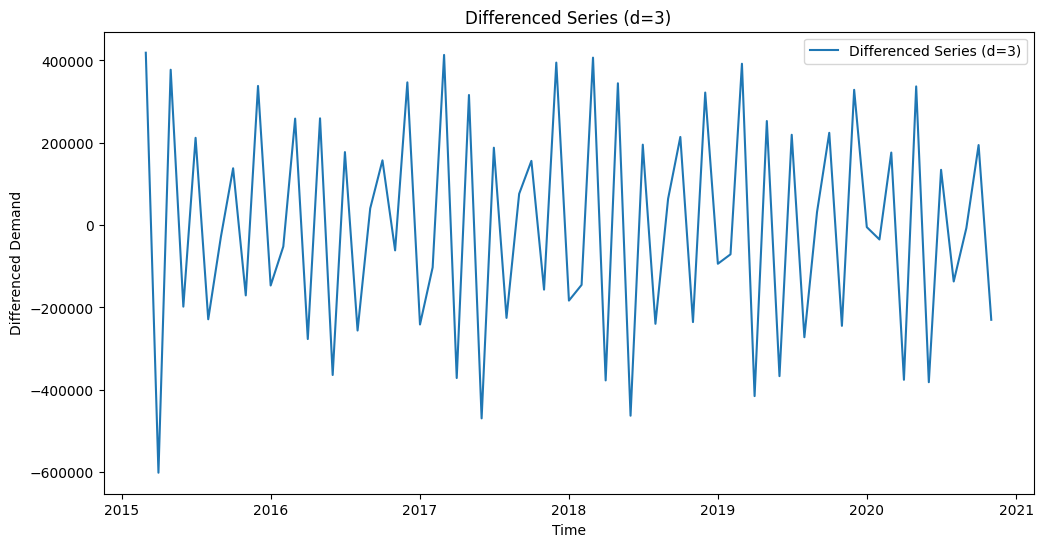

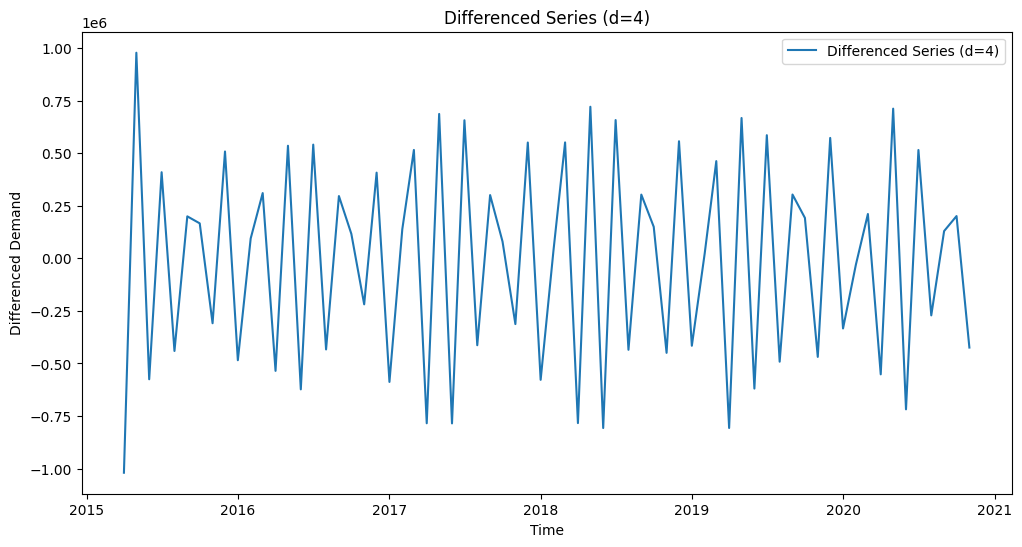

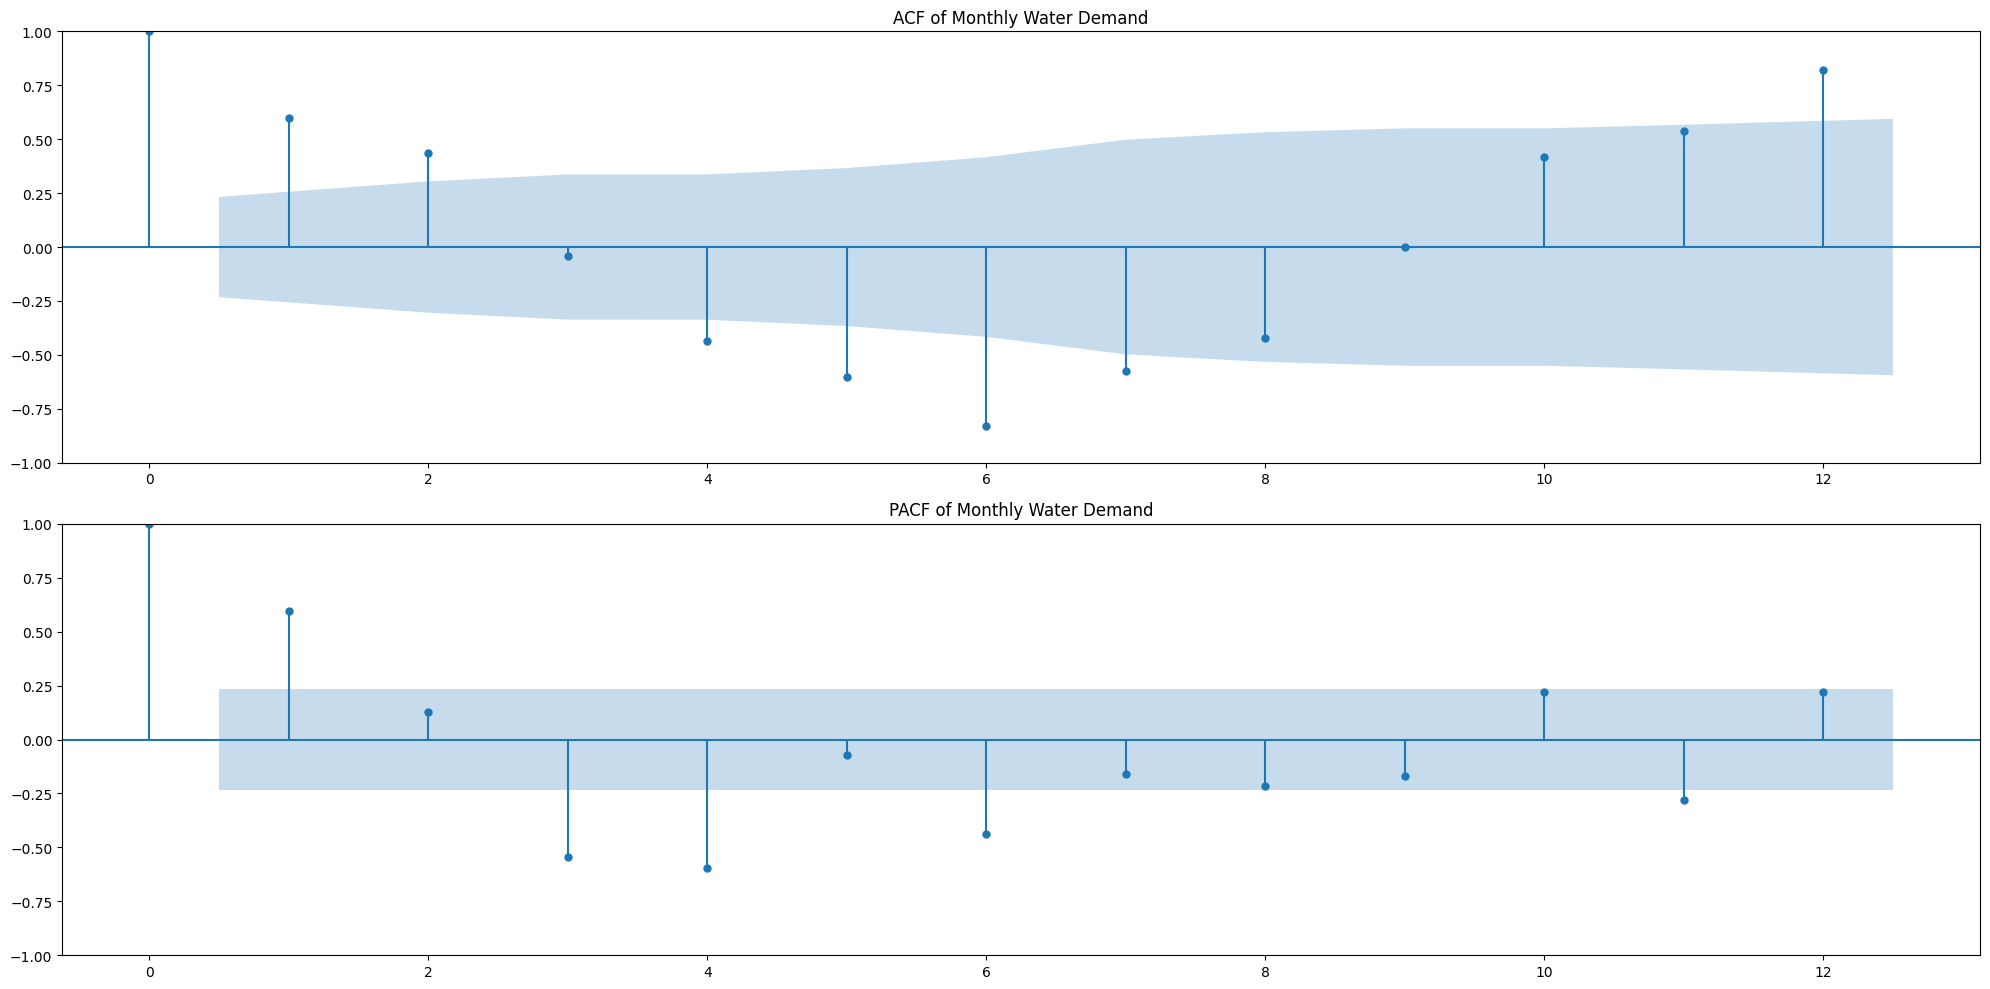

ACF values:
[ 1.          0.5964615   0.43723814 -0.04108489 -0.43601287 -0.6025526
 -0.82836651 -0.57590728 -0.42177414  0.00194558  0.41804081  0.53877773
  0.82112748]

PACF values:
[ 1.          0.60498238  0.13234782 -0.5765543  -0.68093283 -0.1492178
 -0.59162807 -0.48982502 -0.88728595 -6.67401036  1.0634417   0.28868708
  1.01713155]


In [16]:
%matplotlib inline
import matplotlib.pyplot as plt
import statsmodels.api as sm
import pandas as pd

def diff_data(data, d):
    diff_data = data['demand']
    for i in range(d):
        diff_data = diff_data.diff().dropna()
    return diff_data

monthly_diff = diff_data(train, 1)

# Tính toán ACF và PACF
acf_values = sm.tsa.acf(monthly_diff, nlags=12)
pacf_values = sm.tsa.pacf(monthly_diff, nlags=12)

# Vẽ ACF và PACF
fig, ax = plt.subplots(2, 1, figsize=(20, 10))

# Vẽ biểu đồ ACF
sm.graphics.tsa.plot_acf(monthly_diff, lags=12, ax=ax[0])
ax[0].set_title('ACF of Monthly Water Demand')

# Vẽ biểu đồ PACF
sm.graphics.tsa.plot_pacf(monthly_diff, lags=12, ax=ax[1])
ax[1].set_title('PACF of Monthly Water Demand')

# Hiển thị đồ thị
plt.tight_layout()
plt.show()

# In ra các giá trị ACF và PACF
print("ACF values:")
print(acf_values)

print("\nPACF values:")
print(pacf_values)

Kiểm tra tính dừng của yếu tố mùa vụ

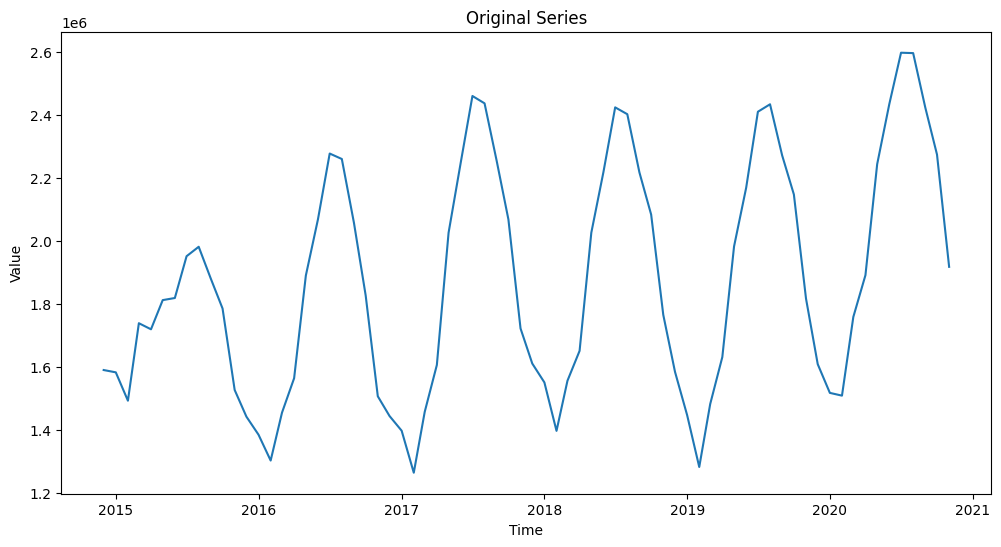

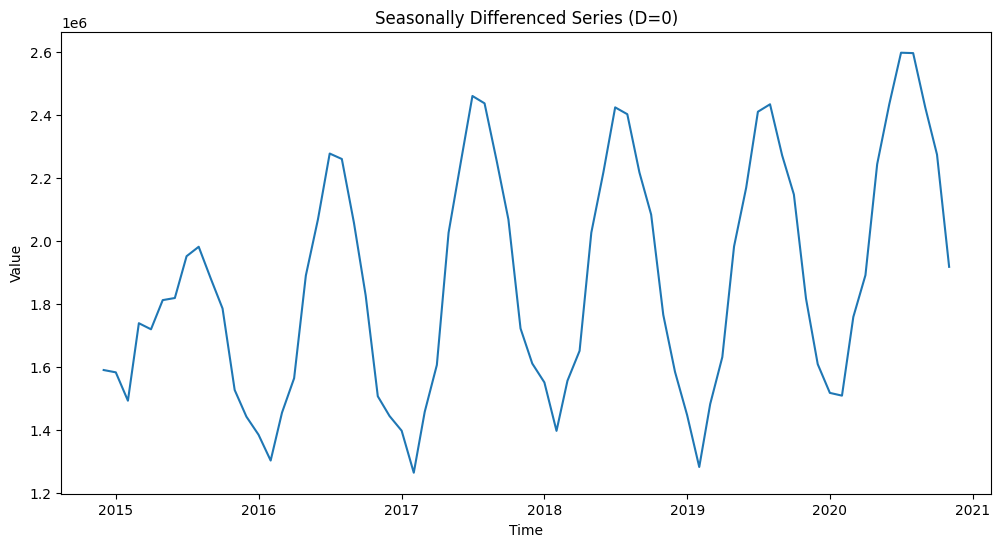

Seasonally Differenced Series (D=0):
ADF Statistic: -1.1295183756961609
p-value: 0.7031579435429764
Critical Values: {'1%': -3.5463945337644063, '5%': -2.911939409384601, '10%': -2.5936515282964665}



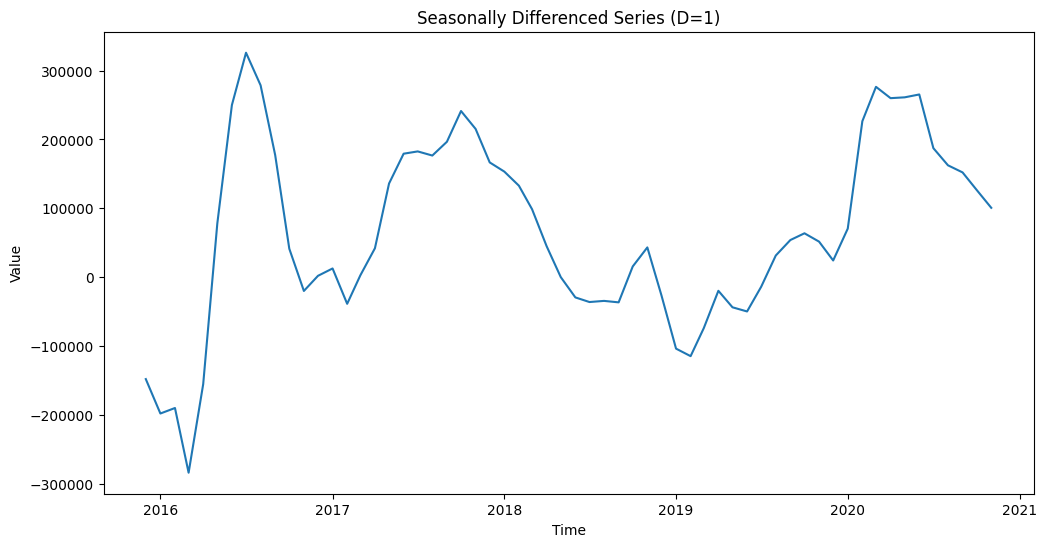

Seasonally Differenced Series (D=1):
ADF Statistic: -4.5702170104285145
p-value: 0.00014651978137998192
Critical Values: {'1%': -3.552928203580539, '5%': -2.9147306250000002, '10%': -2.595137155612245}



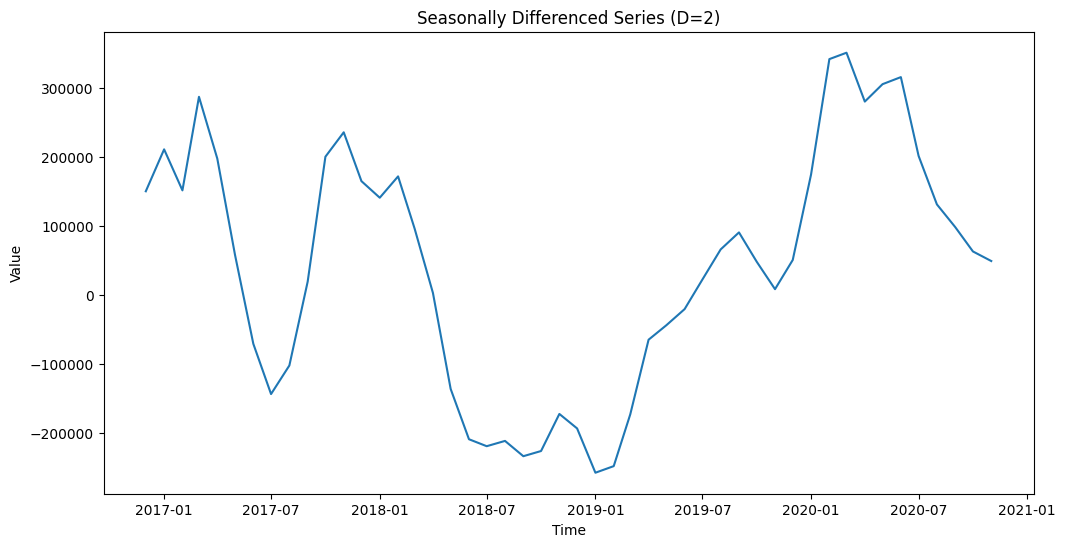

Seasonally Differenced Series (D=2):
ADF Statistic: -2.4559042125095703
p-value: 0.12657514780189455
Critical Values: {'1%': -3.5885733964124715, '5%': -2.929885661157025, '10%': -2.6031845661157025}



In [17]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller

def test_stationarity(series, title='Series'):
    result = adfuller(series.dropna(), autolag='AIC')
    print(f'{title}:')
    print(f'ADF Statistic: {result[0]}')
    print(f'p-value: {result[1]}')
    print('Critical Values:', result[4])
    print('')

def plot_series(series, title='Series'):
    plt.figure(figsize=(12, 6))
    plt.plot(series)
    plt.title(title)
    plt.xlabel('Time')
    plt.ylabel('Value')
    plt.show()

# Vẽ chuỗi thời gian gốc
plot_series(train['demand'], title='Original Series')

def seasonal_difference(data, s, d):
    differenced = train['demand']
    for _ in range(d):
        differenced = differenced - differenced.shift(s)
    return differenced.dropna()

s = 12  

# Kiểm tra các giá trị của D
for d in range(0, 3):  
    diff_data = seasonal_difference(train, s, d)
    plot_series(diff_data, title=f'Seasonally Differenced Series (D={d})')
    test_stationarity(diff_data, title=f'Seasonally Differenced Series (D={d})')

Vẽ ACF, PACF của dữ liệu đã sai phân mùa vụ

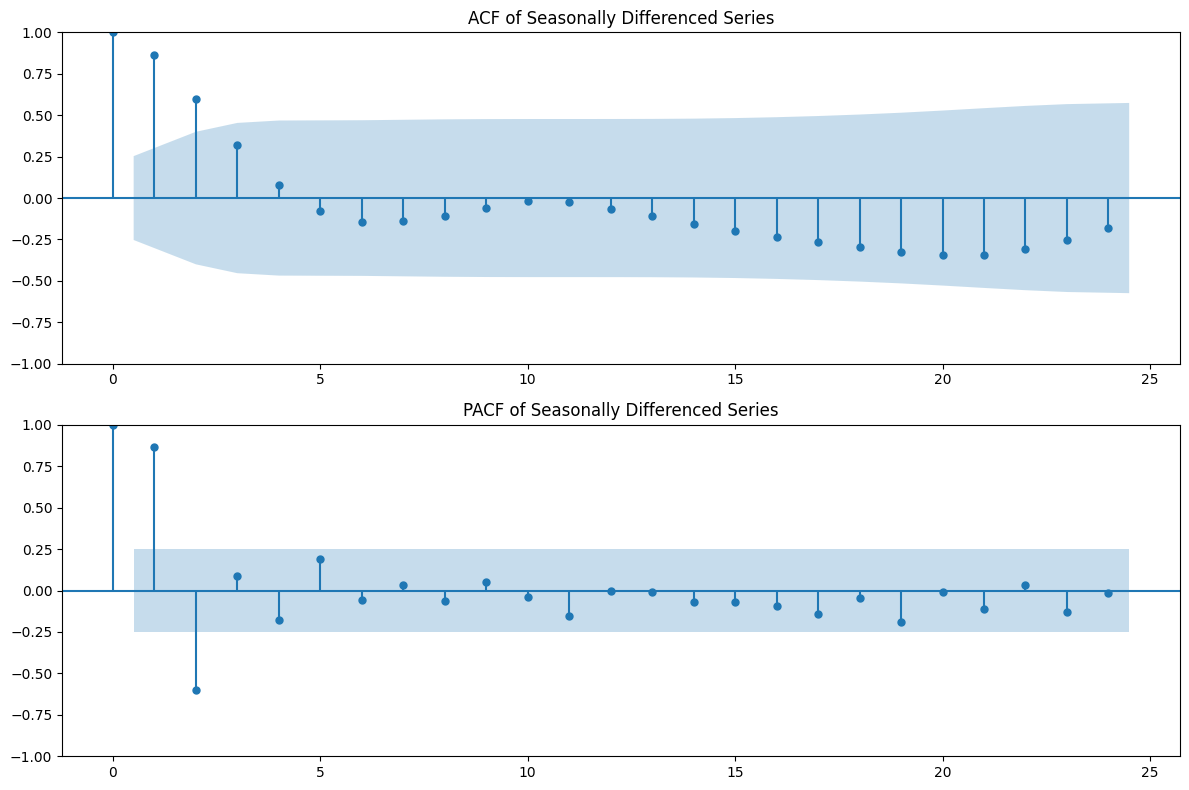

ACF values:
[ 1.          0.86529161  0.59769041  0.32239667  0.07973785 -0.07795996
 -0.14158286 -0.13965716 -0.10566571 -0.05998418 -0.02057075 -0.02288243
 -0.06314448 -0.11030748 -0.15823689 -0.20131674 -0.23288537 -0.26522489
 -0.29529832 -0.32620296 -0.34572289 -0.34232965 -0.30909878 -0.25026743
 -0.17896936]

PACF values:
[ 1.00000000e+00  8.79957571e-01 -6.91370916e-01  2.33473777e-01
 -3.37173231e-01  4.77279391e-01 -5.27174908e-01  9.10978833e-01
 -1.02094758e+01 -1.10286862e+00  5.55934510e-01 -6.27687589e-01
  5.28938854e-01 -8.18939722e-01  3.24305718e+00  1.48952884e+00
 -7.42761826e-01  2.64701556e-01 -4.77798243e-01 -6.88214579e-03
 -3.42716085e-01 -4.86236939e-02 -2.00242115e-01 -2.97227190e-01
 -3.56527812e-01]


In [18]:
diff_train = seasonal_difference(train, 12, 1)

# Tính toán ACF và PACF
acf_values = sm.tsa.acf(diff_train, nlags=24)
pacf_values = sm.tsa.pacf(diff_train, nlags=24)

# Vẽ ACF và PACF
fig, ax = plt.subplots(2, 1, figsize=(12, 8))

# Vẽ biểu đồ ACF
sm.graphics.tsa.plot_acf(diff_train, lags=24, ax=ax[0])
ax[0].set_title('ACF of Seasonally Differenced Series')

# Vẽ biểu đồ PACF
sm.graphics.tsa.plot_pacf(diff_train, lags=24, ax=ax[1])
ax[1].set_title('PACF of Seasonally Differenced Series')

plt.tight_layout()
plt.show()

# In ra các giá trị ACF và PACF
acf_array = np.array(acf_values)
pacf_array = np.array(pacf_values)

# In mảng ACF
print("ACF values:")
print(acf_array)

# In mảng PACF
print("\nPACF values:")
print(pacf_array)

In [19]:
import pandas as pd
from statsmodels.tsa.statespace.sarimax import SARIMAX
import numpy as np
import plotly.graph_objects as go

exp_smooth_train = train['demand']
exp_smooth_test = test['demand']

# Tạo mô hình SARIMA với tham số tốt nhất
model = SARIMAX(exp_smooth_train,
                order=(1, 3, 2),  # Best Order from grid search
                seasonal_order=(1, 1, 0, 12),  # Best Seasonal Order from grid search
                enforce_stationarity=False,
                enforce_invertibility=False)

# Huấn luyện mô hình
sarima_fit = model.fit(disp=False)

# Dự đoán với mô hình SARIMA
y_hat_sarima = sarima_fit.get_forecast(steps=len(exp_smooth_test)).predicted_mean

# Tạo DataFrame cho dự đoán SARIMA
sarima_forecast = pd.DataFrame({
    'ds': exp_smooth_test.index,
    'yhat': y_hat_sarima
})

# Biểu đồ dự đoán so với thực tế
fig = go.Figure()
fig.add_trace(go.Scatter(x=exp_smooth_test.index, y=exp_smooth_test,
                         mode='lines',
                         name='Test - Ground Truth'))
fig.add_trace(go.Scatter(x=sarima_forecast.ds, y=sarima_forecast.yhat,
                         mode='lines', 
                         name='Test - Prediction'))

# Điều chỉnh bố cục
fig.update_traces(line=dict(width=0.5))
fig.update_layout(title='SARIMA Forecast of Monthly Water Demand',
                  xaxis_title='Date (yyyy/mm/dd)',
                  yaxis_title='Energy Demand [MW]')
fig.show()

# Tính toán MAPE
def mape(y_true, y_pred):
    """ Mean Absolute Percentage Error """
    
    # convert to numpy arrays
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    
    # take the percentage error
    pe = (y_true - y_pred) / y_true
    
    # take the absolute values
    ape = np.abs(pe)
    
    # quantify the performance in a single number
    mape = np.mean(ape)
    
    return f'{mape*100:.2f}%'

# Tính toán MAPE
mape_value = mape(exp_smooth_test, y_hat_sarima)
print(f'MAPE for SARIMA\'s predictions: {mape_value}')

c:\Users\ACER\.conda\envs\Python\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.

c:\Users\ACER\.conda\envs\Python\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.



MAPE for SARIMA's predictions: 3.77%
